# C

In [2]:
import math
import torch
import numpy as np
import random
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
from torch import nn
from torch import optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Appendice

In [ ]:
#APPENDICE
def align_matrices_svd(A: torch.Tensor, B: torch.Tensor):
    U_A, _, _ = torch.linalg.svd(A, full_matrices=False)
    U_B, _, _ = torch.linalg.svd(B, full_matrices=False)

    R = U_A @ U_B.T

    return  R

def align_matrices_svd_topk(A: torch.Tensor, B: torch.Tensor, k: int):
    U_A, _, _ = torch.linalg.svd(A, full_matrices=False)
    U_B, _, _ = torch.linalg.svd(B, full_matrices=False)

    U_A_k = U_A[:, :k]
    U_B_k = U_B[:, :k]

    M = U_A_k @ U_B_k.T
    U, _, Vh = torch.linalg.svd(M)
    R = U @ Vh

    return R



def autovettori_svd(model_a, model_b, layer_names):
    rotated_model = MLPModel_mnist()

    R_prev = None
    for i, layer in enumerate(layer_names):
        W_a = getattr(model_a, layer).weight.data
        W_b = getattr(model_b, layer).weight.data
        b_b = getattr(model_b, layer).bias.data

        if i == 0:
            R = align_matrices_svd(W_a, W_b)
            W_new = R @ W_b
            b_new = b_b
            R_prev = R
        else:
            R = align_matrices_svd(W_a, W_b @ R_prev.T)
            W_new = R @ W_b @ R_prev.T
            b_new =  b_b
            R_prev = R
        layer_obj = getattr(rotated_model, layer)
        with torch.no_grad():
            layer_obj.weight.copy_(W_new)
            layer_obj.bias.copy_(b_new)

    final_layer_name = 'fc4'
    final_layer_model_b = getattr(model_b, final_layer_name)
    W_final = final_layer_model_b.weight.data.clone()
    b_final = final_layer_model_b.bias.data.clone()

    final_layer_rotated = getattr(rotated_model, final_layer_name)
    with torch.no_grad():
        final_layer_rotated.weight.data.copy_(W_final @ R_prev.T)
        final_layer_rotated.bias.data.copy_(b_final)


    return rotated_model


#non funziona

autovettori_model=autovettori_svd(model_a, model_b, layer_names)
_,_=comparison_interpolation_method(model_a,model_b,autovettori_model,lambdas,valid_loader3,loss_fn,'autovettori')
interpolate_models_slerp(model_a, model_b, autovettori_model, lambdas,valid_loader3)

In [ ]:

def compute_covariance(Z):
    # Z: neurons x examples
    Z_centered = Z - torch.mean(Z, axis=1, keepdims=True)
    C = (Z_centered @ Z_centered.T) / (Z.shape[1] - 1)
    return C

def procrustes_align(U_A, U_B):
    M = U_A @ U_B.T
    U, _, Vt = np.linalg.svd(M)
    Q = U @ Vt
    return Q

def spectral_covariance(model_a, model_b, layer_names,dataloader):
    rotated_model=MLPModel_mnist()
    R_prev=None
    dizA =get_multiple_fc_activations(model_a, layer_names, dataloader, max_batches=5)  # shape: (n, d)
    dizB = get_multiple_fc_activations(model_b, layer_names,dataloader, max_batches=5)
    for n,layer in enumerate(layer_names):
        Z_A = dizA[layer]  #512,640
        Z_B = dizB[layer]
        C_A = compute_covariance(Z_A)
        C_B = compute_covariance(Z_B)
        R=procrustes_align( C_A,C_B)
        layer_obj = getattr(model_b, layer)
        W = layer_obj.weight.data.clone()
        b = layer_obj.bias.data.clone()
        if n>0:
          W_new =  R @ W @ R_prev.T
        else:
          W_new = R @ W

        b_new = R@ b  #R@b
        R_prev = R

        layer_rotated = getattr(rotated_model, layer)
        with torch.no_grad():
            layer_rotated.weight.data.copy_(W_new)
            layer_rotated.bias.data.copy_(b_new)

    final_layer_name = 'fc4'
    final_layer_model_b = getattr(model_b, final_layer_name)
    W_final = final_layer_model_b.weight.data.clone()
    b_final = final_layer_model_b.bias.data.clone()

    final_layer_rotated = getattr(rotated_model, final_layer_name)
    with torch.no_grad():
        final_layer_rotated.weight.data.copy_(W_final @ R_prev.T)
        final_layer_rotated.bias.data.copy_(b_final)


    return rotated_model
p=spectral_covariance(model_a, model_b, layer_names,valid_loader3)
_,_=comparison_interpolation_method(model_a,model_b,p,lambdas,valid_loader4,loss_fn,'sd')
interpolate_models_slerp(model_a, model_b, p, lambdas,valid_loader4)

In [ ]:
def find_R(W_a,W_b):
  M = W_a @ W_b.T
  S=(M+M.T)/2
  eigenvalues, eigenvectors = torch.linalg.eigh(S)
  return eigenvectors


def spectral_decomposition(model_a, model_b, layer_names):
    rotated_weight_b = MLPModel_mnist()
    R_prev = None
    for n, layer in enumerate(layer_names):
        W_a = getattr(model_a, layer).weight.data
        W_b = getattr(model_b, layer).weight.data
        b_b = getattr(model_b, layer).bias.data
        if n == 0:
            R= find_R(W_a, W_b)
            W_new = R @ W_b
            b_new = R @ b_b
        else:
            R= find_R(W_a, W_b @R_prev.T)
            W_new = R @ W_b @ R_prev.T
            b_new = R @ b_b

        R_prev = R

        layer_obj = getattr(rotated_weight_b, layer)
        with torch.no_grad():
            layer_obj.weight.copy_(W_new)
            layer_obj.bias.copy_(b_new)
    final_layer_name = 'fc4'
    W_final = getattr(model_b, final_layer_name).weight.data.clone()
    b_final = getattr(model_b, final_layer_name).bias.data.clone()

    with torch.no_grad():
        getattr(rotated_weight_b, final_layer_name).weight.copy_( W_final @ R_prev.T)
        getattr(rotated_weight_b, final_layer_name).bias.copy_(b_final)

    return rotated_weight_b



In [ ]:
import torch.nn.functional as F
def find_reflection_R(Z_A, Z_B, epochs=25, lr=1e-2):
    dim = Z_A.size(0)
    u = torch.randn(dim, requires_grad=True)
    with torch.no_grad():
       u /= u.norm()
    optimizer = torch.optim.Adam([u], lr=lr)

    for _ in range(epochs):
        optimizer.zero_grad()
        u_norm = u / u.norm()
        R = torch.eye(dim, device=u.device) - 2 * torch.ger(u_norm, u_norm)
        ZB_reflected = R @ Z_B
        loss = F.mse_loss(ZB_reflected, Z_A)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            u.copy_(u / u.norm())
    return R

def reflection_matrix(Z_a, Z_b):
    M = 0.5 * (Z_b @ Z_a.T + Z_a @ Z_b.T)
    eigvals, eigvecs = torch.linalg.eigh(M)
    v = eigvecs[:, torch.argmin(eigvals)]
    R = torch.eye(Z_a.shape[0]) - 2.0 * torch.outer(v, v)
    return R



def reflects_activations(model_a, model_b, layer_names, dataloader):
    rotated_model = MLPModel_mnist()
    #err_pre,err_post,err_relu=[],[],[]
    dizA =get_multiple_fc_activations(model_a, layer_names, dataloader, max_batches=5)  # shape: (n, d)
    dizB = get_multiple_fc_activations(model_b, layer_names,dataloader, max_batches=5)
    for n,layer in enumerate(layer_names):
        Z_A = dizA[layer]  #512,640
        Z_B = dizB[layer]
        R=reflection_matrix(Z_A, Z_B)
        layer_obj = getattr(model_b, layer)
        W = layer_obj.weight.data.clone()
        b = layer_obj.bias.data.clone()
        if n>0:
          W_new =  R @ W @ R_prev.T
        else:
          W_new = R @ W

        b_new = R@ b  #R@b
        R_prev = R

        layer_rotated = getattr(rotated_model, layer)
        with torch.no_grad():
            layer_rotated.weight.data.copy_(W_new)
            layer_rotated.bias.data.copy_(b_new)

       # pre,post=error_non_commutativity(Z_A,Z_B,R)
        #err_pre.append(pre.item())
        #err_post.append(post.item())
        #relu=post-pre
       # err_relu.append(relu.item())
    final_layer_name = 'fc4'
    final_layer_model_b = getattr(model_b, final_layer_name)
    W_final = final_layer_model_b.weight.data.clone()
    b_final = final_layer_model_b.bias.data.clone()

    final_layer_rotated = getattr(rotated_model, final_layer_name)
    with torch.no_grad():
        final_layer_rotated.weight.data.copy_(W_final @ R_prev.T)
        final_layer_rotated.bias.data.copy_(b_final)


    return rotated_model

#interpolaziome "sballata",APPENDICE

In [ ]:
#APPENDICE
import torch.nn.functional as F
import copy


def slerp(v0, v1, alpha):
    """Spherical linear interpolation between two unit vectors v0 and v1"""
    dot = torch.clamp(torch.dot(v0, v1), -1.0, 1.0)
    omega = torch.acos(dot)
    so = torch.sin(omega)
    if so < 1e-6:
        return (1.0 - alpha) * v0 + alpha * v1
    return (torch.sin((1.0 - alpha) * omega) / so) * v0 + (torch.sin(alpha * omega) / so) * v1

def find_reflection_u(Z_A, Z_B, epochs=25, lr=1e-2):
    dim = Z_A.size(0)
    u = torch.randn(dim, requires_grad=True)
    with torch.no_grad():
       u /= u.norm()
    optimizer = torch.optim.Adam([u], lr=lr)

    for _ in range(epochs):
        optimizer.zero_grad()
        u_norm = u / u.norm()
        R = torch.eye(dim, device=u.device) - 2 * torch.ger(u_norm, u_norm)
        ZB_reflected = R @ Z_B
        loss = F.mse_loss(ZB_reflected, Z_A)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            u.copy_(u / u.norm())
    return u / u.norm()

from copy import deepcopy


def interpolate_models_slerp_u(model_a, model_b, layer_names, dataloader, alphas, loss_fn):
    dizA = get_multiple_fc_activations(model_a, layer_names, dataloader, max_batches=5)
    dizB = get_multiple_fc_activations(model_b, layer_names, dataloader, max_batches=5)

    u_layers = {}
    dim = None

    # Calcolo dei vettori di riflessione u
    for layer in layer_names:
        Z_A = dizA[layer]
        Z_B = dizB[layer]
        u = find_reflection_u(Z_A, Z_B)
        u_layers[layer] = u
        dim = Z_A.size(0)

    # Vettore base per l’identità
    u_id = torch.zeros(dim, device=Z_A.device)
    u_id[0] = 1.0

    losses = []
    accuracies = []

    for alpha in alphas:
        model_interp = deepcopy(model_a)
        R_prev = None

        with torch.no_grad():
            for name in layer_names:
                layer_a = getattr(model_a, name)
                layer_b = getattr(model_b, name)
                layer_i = getattr(model_interp, name)

                u = u_layers[name]
                u_alpha = slerp(u_id, u, alpha)
                u_alpha = u_alpha / u_alpha.norm()

                R_alpha = torch.eye(dim, device=u.device) - 2 * torch.ger(u_alpha, u_alpha)

                Wa = layer_a.weight.data
                Wb = layer_b.weight.data
                ba = layer_a.bias.data
                bb = layer_b.bias.data

                if R_prev is not None:
                    Wb_rot = R_alpha @ Wb @ R_prev.T
                else:
                    Wb_rot = R_alpha @ Wb

                bb_rot =  bb

                W_interp = (1 - alpha) * Wa + alpha * Wb_rot
                b_interp = (1 - alpha) * ba + alpha * bb_rot

                layer_i.weight.copy_(W_interp)
                layer_i.bias.copy_(b_interp)

                R_prev = R_alpha

        # Valutazione
        model_interp.eval()
        loss, acc = evaluate_loss(model_interp, dataloader, loss_fn)
        losses.append(loss)
        accuracies.append(acc)

    return losses, accuracies


# CIFAR

In [3]:
class MLPModel_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)       # primo fully connected layer
        self.fc2 = nn.Linear(512, 512)       # secondo fully connected layer
        self.fc3 = nn.Linear(512, 512)       # terzo fully connected layer
        self.fc4 = nn.Linear(512, 10)        # output layer 10 classi

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        xb = self.fc1(xb)                # primo layer fully connected
        xb = F.relu(xb)                  # ReLU

        xb = self.fc2(xb)                # secondo layer fully connected
        xb = F.relu(xb)                  # ReLU

        xb = self.fc3(xb)                # terzo layer fully connected
        xb = F.relu(xb)                  # ReLU

        xb = self.fc4(xb)                # layer finale (lineare)
        xb = F.log_softmax(xb, dim=-1)   # log-softmax

        return xb

model=MLPModel_cifar()
layer_names = ['fc1', 'fc2', 'fc3']

# Dataset Cifar10

In [4]:
import random
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

g1 = torch.Generator()
g1.manual_seed(42)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

train_size = int(0.75 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset_a, valid_dataset_a = random_split(dataset, [train_size, valid_size], generator=g1)
valid_dataset_a.dataset.transform = transform_val


train_loader_a = DataLoader(train_dataset_a, batch_size=64, shuffle=True, num_workers=2)
valid_loader_a= DataLoader(valid_dataset_a, batch_size=64, shuffle=False, num_workers=2)

g2 = torch.Generator()
g2.manual_seed(123)

train_dataset_b, valid_dataset_b = random_split(dataset, [train_size, valid_size], generator=g2)
train_loader_b = DataLoader(train_dataset_b, batch_size=64, shuffle=True, num_workers=2)
valid_loader_b= DataLoader(valid_dataset_b, batch_size=64, shuffle=False, num_workers=2)

g3 = torch.Generator()
g3.manual_seed(333)

train_dataset_3, valid_dataset_3 = random_split(dataset, [train_size, valid_size], generator=g3)
train_loader_3 = DataLoader(train_dataset_3, batch_size=64, shuffle=True, num_workers=2)
valid_loader_3= DataLoader(valid_dataset_3, batch_size=64, shuffle=False, num_workers=2)


g4 = torch.Generator()
g4.manual_seed(999)

train_dataset_4, valid_dataset_4 = random_split(dataset, [train_size, valid_size], generator=g4)
train_loader_4 = DataLoader(train_dataset_4, batch_size=64, shuffle=True, num_workers=2)
valid_loader_4= DataLoader(valid_dataset_4, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


# Train

In [18]:
import matplotlib.pyplot as plt
def train(model,train_dl,valid_dl,save_prefix):
      loss_func = F.cross_entropy
      epochs = 12
      lr = 0.001
      losses = torch.zeros(epochs)
      val_losses = torch.zeros(epochs)
      opt = optim.Adam(model.parameters(), lr=lr)

      valid_accuracy = torch.zeros(epochs)

      for epoch in range(epochs):
          model.train()
          train_loss = 0
          total = 0
          for xb, yb in train_dl:
              pred = model(xb)
              loss = loss_func(pred, yb)
              loss.backward()
              opt.step()
              opt.zero_grad()
              train_loss += loss.item() * xb.size(0)
              total += xb.size(0)
          losses[epoch] = train_loss / total


          model.eval()
          val_loss = 0
          total = 0
          correct= 0
          with torch.no_grad():
              for xv, yv in valid_dl:
                  outputs = model(xv)
                  val_loss += loss_func(outputs, yv).item() * xv.size(0)
                  predicted = outputs.argmax(dim=1)
                  correct += (predicted == yv).sum().item()
                  total += yv.size(0)
              valid_accuracy[epoch] = correct / total
              val_losses[epoch] = val_loss / total

          if not epoch % 10:
              print(epoch, loss.item())

      plt.figure(figsize=(6, 3))
      plt.plot(valid_accuracy, label='validation', color='red')
      plt.xlabel('epochs')
      plt.ylabel('accuracy')
      plt.xlim(-1, epochs + 1)
      plt.ylim(0.1, 1)
      plt.legend()
      plt.grid(True)
      plt.show()
      plt.figure(figsize=(6, 3))
      plt.plot(losses, color='red', label='train')
      plt.plot(val_losses.detach().numpy(), color='black', label='val')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.grid(True)
      plt.legend()
      plt.show()

      print(f"final validation accuracy: {valid_accuracy[-1]*100:.2f}%")


0 1.8833918571472168
10 1.3387627601623535


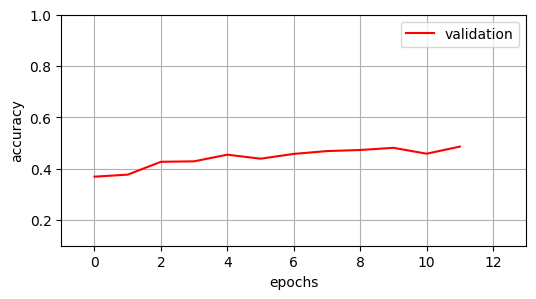

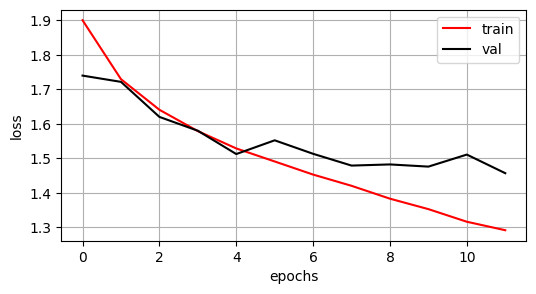

final validation accuracy: 48.61%


In [ ]:
#model_a_cifar = MLPModel_cifar()
#train(model_a_cifar,train_loader_a,valid_loader_a,valid_dataset_a)


0 1.6654115915298462
10 1.3965381383895874


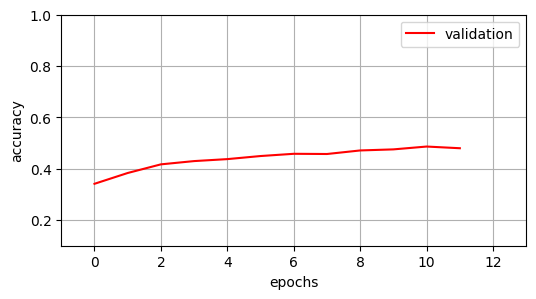

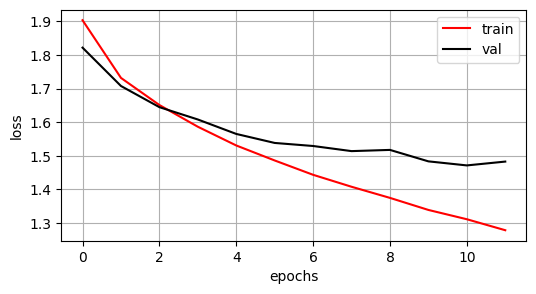

final validation accuracy: 47.98%


In [ ]:
#model_b_cifar = MLPModel_cifar()
#train(model_b_cifar,train_loader_b,valid_loader_b,valid_dataset_b)

# Download and upload

In [ ]:
from google.colab import files
torch.save(model_a_cifar.state_dict(), "model_a_cifar_weights.pt")
files.download("model_a_cifar_weights.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model_b_cifar.state_dict(), "model_b_cifar_weights.pt")
files.download("model_b_cifar_weights.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from google.colab import files
uploaded = files.upload()
model_cifar_a=MLPModel_cifar()
model_cifar_b=MLPModel_cifar()

model_cifar_a.load_state_dict(torch.load("model_a_cifar_weights.pt"))
model_cifar_b.load_state_dict(torch.load("model_b_cifar_weights.pt"))

Saving model_a_cifar_weights.pt to model_a_cifar_weights (1).pt
Saving model_b_cifar_weights.pt to model_b_cifar_weights.pt


<All keys matched successfully>

# Useful

In [14]:
def comparison_interpolation_method(model_a,model_b,perm_model,lambdas,valid_dl,loss_fn,stringa):
    val_losses_ab ,acc_ab= [],[]
    val_losses_ap ,acc_ap= [],[]
    for lam in lambdas:
        interpolated = interpolate_models(model_a, model_b, lam)
        loss,acc = evaluate_loss(interpolated, valid_dl, loss_fn)
        acc_ab.append(acc)
        val_losses_ab.append(loss)

        interpolated_p = interpolate_models(model_a, perm_model, lam)
        loss_p,acc_p = evaluate_loss(interpolated_p, valid_dl, loss_fn)
        acc_ap.append(acc_p)
        val_losses_ap.append(loss_p)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(lambdas, val_losses_ab, marker='o', label="Naive A ↔ B")
    axs[0].plot(lambdas, val_losses_ap, marker='s', label=stringa)
    axs[0].set_xlabel("λ (interpolation factor)")
    axs[0].set_ylabel("Validation Loss")
    axs[0].set_title("Validation Loss - Interpolation Between Models")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(lambdas, acc_ab, marker='o', label=" Naive A ↔ B")
    axs[1].plot(lambdas, acc_ap, marker='s', label=stringa)
    axs[1].set_xlabel("λ (interpolation factor)")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy - Interpolation Between Models")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return val_losses_ap ,acc_ap

In [9]:
layer_names = ['fc1', 'fc2', 'fc3']
lambdas = np.linspace(0, 1, 25)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
import copy
def interpolate_models(model_a, model_b, alpha):
    new_model = copy.deepcopy(model_a)
    with torch.no_grad():
        for (pa, pb, pc) in zip(model_a.parameters(), model_b.parameters(), new_model.parameters()):
            pc.data = (1 - alpha) * pa.data + alpha * pb.data
    return new_model

def evaluate_loss(model, dataloader, loss_fn):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xv, yv in dataloader:
            outputs = model(xv)
            val_loss += loss_fn(outputs, yv).item() * xv.size(0)

            predicted = outputs.argmax(dim=1)
            correct += (predicted == yv).sum().item()
            total += yv.size(0)
    avg_loss = val_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [11]:

def get_multiple_fc_activations(model, layer_names, dataloader, max_batches=5):
    import gc

    activations_dict = {name: [] for name in layer_names}

    def get_hook(name):
        def hook_fn(module, input, output):
            activations_dict[name].append(output.detach().cpu())
        return hook_fn

    handles = []
    for name, module in model.named_modules():
        if name in layer_names:
            handle = module.register_forward_hook(get_hook(name))
            handles.append(handle)

    model = model.to("cpu")
    model.eval()

    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            if i >= max_batches:
                break
            inputs = inputs.to("cpu")
            model(inputs)


    for handle in handles:
        handle.remove()


    gc.collect()
    torch.cuda.empty_cache()

    Z_dict = {}
    for name, acts in activations_dict.items():
        all_acts = torch.cat(acts, dim=0)
        Z = all_acts.T
        Z_dict[name] = Z

    return Z_dict

In [12]:
def comparison_naive(model_a,model_b,valid_dl,loss_fn):
    val_losses_ab ,acc_ab= [],[]
    for lam in lambdas:
        interpolated = interpolate_models(model_a, model_b, lam)
        loss,acc = evaluate_loss(interpolated, valid_dl, loss_fn)
        acc_ab.append(acc)
        val_losses_ab.append(loss)
    return  val_losses_ab ,acc_ab


# Permutations

## Matching activations

In [13]:
from scipy.optimize import linear_sum_assignment

def compute_permutation_matrix(Z_A: torch.Tensor, Z_B: torch.Tensor) :
    Z_A_np = Z_A.cpu().numpy() #512,640
    Z_B_np = Z_B.cpu().numpy()

    d = Z_A_np.shape[0]
    cost_matrix = np.linalg.norm(Z_A_np[:, None, :] - Z_B_np[None, :, :], axis=2)**2

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    P = np.zeros((d, d), dtype=np.float32)
    P[row_ind, col_ind] = 1.0

    return torch.from_numpy(P)

def residual_misalignment_error(Z_A, Z_B, P):
    Z_diff = Z_A - P @ Z_B
    return (Z_diff**2).sum().item() / Z_A.numel()

def permute_activations(model_a, model_b, layer_names, valid_dl):
    perm_model = copy.deepcopy(model_b)
    diz_res,diz_perm={},{}
    dizA = get_multiple_fc_activations(model_a, layer_names, valid_dl)
    dizB = get_multiple_fc_activations(model_b, layer_names, valid_dl)

    for n,layer in enumerate(layer_names):
        Z_A = dizA[layer]
        Z_B = dizB[layer]

        Player = compute_permutation_matrix(Z_A, Z_B)
        diz_res[layer]=residual_misalignment_error(Z_A, Z_B, Player)

        diz_perm[layer]=Player

        layer_obj = getattr(model_b, layer)
        W = layer_obj.weight.data.clone()
        b = layer_obj.bias.data.clone()

        if n>0:
          W_new = Player @ W @ P_prev.T
        else:
          W_new = Player @ W

        b_new = Player @ b
        P_prev = Player

        layer_perm = getattr(perm_model, layer)
        with torch.no_grad():
            layer_perm.weight.data.copy_(W_new)
            layer_perm.bias.data.copy_(b_new)

    final_layer_name = 'fc4'
    final_layer_model_b = getattr(model_b, final_layer_name)
    W_final = final_layer_model_b.weight.data.clone()
    b_final = final_layer_model_b.bias.data.clone()

    final_layer_perm = getattr(perm_model, final_layer_name)
    with torch.no_grad():
        final_layer_perm.weight.data.copy_(W_final @ P_prev.T)
        final_layer_perm.bias.data.copy_(b_final)

    return perm_model,diz_perm

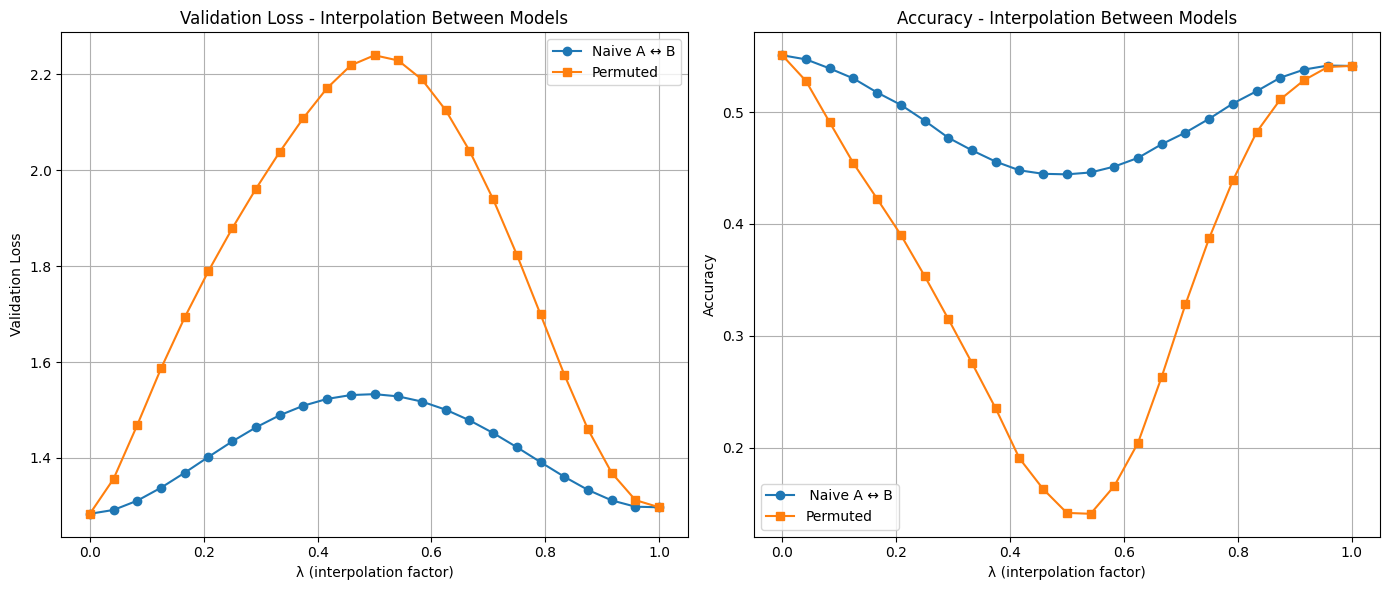

In [19]:
model_act,diz=permute_activations(model_cifar_a, model_cifar_b, layer_names, valid_loader_3)
_,_=comparison_interpolation_method(model_cifar_a,model_act,model_cifar_b,lambdas,valid_loader_3,loss_fn,"Permuted")